## Let's plot the gordon network atlas

In [35]:
# importing the tools we'll use throughout the rest of the script
# sys is system tools, should already be installed
import sys
import json

# pandas is a dataframe-managing library and it's the absolute coolest
import pandas as pd

# numpy is short for "numerical python" and it does math
import numpy as np

# seaborn is a plotting library named after a character from West Wing
# it's kind of like python's ggplot
import seaborn as sns

# nibabel handles nifti images
import nibabel as nib

# os is more system tools, should also already be installed
# we're importing tools for verifying and manipulating file paths/directories
from os.path import join, exists, isdir
from os import makedirs

# nilearn makes the best brain plots
# and their documentation/examples are so, so handy
# https://nilearn.github.io/stable/auto_examples/01_plotting/index.html
from nilearn import plotting, surface, datasets

# matplotlib is the backbone of most python plotting
import matplotlib as mpl
import matplotlib.pyplot as plt

# gridspec helps us put lots of panels on one figure
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap

%matplotlib inline

In [36]:
fig_dir = "./derivatives/none-reduced/figures"

In [37]:
def assign_region_names(df, missing=False):
    """
    Input:
    df = dataframe (variable x columns) with column containing region names in ABCD var ontology,
    Output:
    df = same dataframe, but with column mapping region variables to actual region names
    missing = optional, list of ABCD region names not present in region_names dictionary
    """

    # read in region names
    with open(
        "/Volumes/projects_herting/LABDOCS/PROJECTS/ABCD/Data/release4.0/python_scripts/abcd_vars_to_region_names.json"
    ) as json_file:
        region_names = json.load(json_file)

    missing = []
    if not "long_region" in df.columns:
        df["measure"] = ""
        df["region"] = ""
        df["modality"] = ""
        df["atlas"] = ""
        df["long_region"] = ""
        df["hemisphere"] = ""
        for var in df.index:
            # print(var)
            if "mrisdp" in var:
                var_num = int(var.split(".")[0].split("_")[-1])
                df.at[var, "modality"] = "smri"
                df.at[var, "atlas"] = "dtx"
                if var_num <= 148:
                    df.at[var, "measure"] = "thick"
                elif var_num <= 450 and var_num >= 303:
                    df.at[var, "measure"] = "area"
                elif var_num < 604 and var_num >= 450:
                    df.at[var, "measure"] = "vol"
                elif var_num <= 1054 and var_num >= 907:
                    df.at[var, "measure"] = "t1wcnt"
                elif var_num == 604:
                    df.at[var, "measure"] = "gmvol"
            elif "_" in var:
                var_list = var.split(".")[0].split("_")
                df.at[var, "modality"] = var_list[0]
                df.at[var, "measure"] = var_list[1]
                df.at[var, "atlas"] = var_list[2]
                region = "_".join(var_list[3:])
                df.at[var, "region"] = region
                if "scs" in var:
                    if "rsirni" in var:
                        df.at[var, "measure"] = "rsirnigm"
                    elif "rsirnd" in var:
                        df.at[var, "measure"] = "rsirndgm"
                    else:
                        pass
                else:
                    pass
                if "_scs_" in region:
                    temp = region.split("_scs_")
                    region_name = (
                        f"{region_names[temp[0]][0]}, {region_names[temp[1]][0]}"
                    )
                    hemisphere = region_names[temp[1]][1]
                    df.at[var, "long_region"] = region_name
                    df.at[var, "hemisphere"] = hemisphere
                    df.at[var, "measure"] = "subcortical-network fc"
                elif "_ngd_" in region:
                    temp = region.split("_ngd_")
                    if temp[0] == temp[1]:
                        df.at[var, "measure"] = "within-network fc"
                    else:
                        df.at[var, "measure"] = "between-network fc"
                    region_name = (
                        f"{region_names[temp[0]][0]}, {region_names[temp[1]][0]}"
                    )
                    hemisphere = region_names[temp[1]][1]
                    df.at[var, "long_region"] = region_name
                    df.at[var, "hemisphere"] = hemisphere
                elif str(region) not in (region_names.keys()):
                    missing.append(region)
                else:
                    long_region = region_names[region]
                    df.at[var, "long_region"] = long_region[0]
                    df.at[var, "hemisphere"] = long_region[1]

        df = df[df["measure"] != "t1w"]
        df = df[df["measure"] != "t2w"]
    else:
        pass

    print(f"missed {len(missing)} regions bc they weren't in the dict")
    return df


def plot_surfaces(nifti, surf, cmap, vmax, threshold):
    """
    Plots of medial and lateral left and right surface views from nifti volume
    """
    texture_l = surface.vol_to_surf(nifti, surf.pial_left, interpolation="nearest")
    texture_r = surface.vol_to_surf(nifti, surf.pial_right, interpolation="nearest")

    fig = plt.figure(figsize=(12, 4))
    gs = GridSpec(1, 4)

    ax0 = fig.add_subplot(gs[0], projection="3d")
    ax1 = fig.add_subplot(gs[1], projection="3d")
    ax2 = fig.add_subplot(gs[2], projection="3d")
    ax3 = fig.add_subplot(gs[3], projection="3d")

    fig1 = plotting.plot_img_on_surf(
        nifti,
        cmap=cmap,
        threshold=threshold,
        # vmax=vmax,
        symmetric_cbar=True,
        kwargs={"bg_on_data": True, "alpha": 0.5, "avg_method": "max"},
        # output_file=f'../figures/{cols.name}.png'
    )

    plt.tight_layout(w_pad=-1, h_pad=-1)
    figure = plotting.plot_surf_stat_map(
        surf.pial_left,
        texture_l,
        bg_map=surf.sulc_left,
        symmetric_cbar=True,
        threshold=threshold,
        cmap=cmap,
        view="lateral",
        colorbar=False,
        vmax=vmax,
        axes=ax0,
    )
    figure = plotting.plot_surf_stat_map(
        surf.pial_left,
        texture_l,
        bg_map=surf.sulc_left,
        symmetric_cbar=True,
        threshold=threshold,
        cmap=cmap,
        view="medial",
        colorbar=False,
        vmax=vmax,
        axes=ax1,
    )
    figure = plotting.plot_surf_stat_map(
        surf.pial_right,
        texture_r,
        bg_map=surf.sulc_right,
        symmetric_cbar=True,
        threshold=threshold,
        cmap=cmap,
        view="lateral",
        colorbar=False,
        vmax=vmax,
        axes=ax2,
    )
    figure = plotting.plot_surf_stat_map(
        surf.pial_right,
        texture_r,
        bg_map=surf.sulc_right,
        symmetric_cbar=True,
        threshold=threshold,
        cmap=cmap,
        view="medial",
        colorbar=False,
        vmax=vmax,
        axes=ax3,
    )
    return figure, fig1


def series_2_nifti(series_in, out_dir, save=False):
    nifti_mapping = pd.read_pickle(
        "/Volumes/projects_herting/LABDOCS/Personnel/Katie/deltaABCD_clustering/data/variable_to_nifti_mapping.pkl"
    )
    series = series_in.copy()
    series.index = [x.split(".")[0] for x in series.index]

    # vmin = series.quantile(0.25)

    # list of measures to plot
    measures = {
        "cortical-thickness": "smri_thick_cdk_.*",
        "cortical-gwcontrast": "smri_t1wcnt_cdk_.*",
        "cortical-area": "smri_area_cdk_.*",
        "cortical-volume": "smri_vol_cdk_.*",
        "subcortical-volume": "smri_vol_scs_.*",
        "subcortical-RND": "dmri_rsirnd_scs_.*",
        "subcortical-RNI": "dmri_rsirni_scs_.*",
        "cortical-RND": "dmri_rsirndgm_.*",
        "cortical-RNI": "dmri_rsirnigm_.*",
        "cortical-BOLD-variance": "rsfmri_var_cdk_.*",
        "tract-volume": "dmri_dtivol_fiberat_.*",
        "tract-FA": "dmri_dtifa_fiberat_.*",
        "tract-MD": "dmri_dtimd_fiberat_.*",
        "tract-LD": "dmri_dtild_fiberat_.*",
        "tract-TD": "dmri_dtitd_fiberat_.*",
        "tract-RND": "dmri_rsirnd_fib_.*",
        "tract-RNI": "dmri_rsirni_fib_.*",
    }
    fc_cort_var = series.filter(regex=".*fmri.*_c_.*").index
    fc_scor_var = series.filter(regex=".*fmri.*_cor_.*").index
    fmri_var_var = series.filter(regex=".*fmri.*_var_.*").index

    # morph_var = df[df['concept'] == 'macrostructure'].index
    # cell_var = df[df['concept'] == 'microstructure'].index
    func_var = list(fmri_var_var)
    conn_var = list(fc_cort_var) + list(fc_scor_var)

    conn_measures = {
        "cortical-network-connectivity": "rsfmri_c_ngd_.*",
        "subcortical-network-connectivity": "rsfmri_cor_ngd_.*_scs_.*",
    }

    # let's plot APC on brains pls
    for measure in measures.keys():
        # print(measure, measures[measure])
        # print(measure)

        meas_df = series.filter(regex=measures[measure], axis=0)
        meas_vars = meas_df.index

        # meas_df.drop_duplicates(inplace=True)
        # print(len(meas_df.index))
        # print(meas_df.head())
        if len(meas_df[meas_df != 0]) == 0:
            pass
        else:
            if "tract" in measure:
                # print('tract')
                fibers = nifti_mapping.filter(regex=measures[measure], axis=0).index
                var = fibers[0]
                tract_fname = nifti_mapping.loc[var]["atlas_fname"]
                tract_nii = nib.load(tract_fname)
                tract_arr = tract_nii.get_fdata()
                # print(np.unique(tract_arr))
                avg = series.loc[f"{var}"]
                tract_arr *= avg
                all_tracts_arr = np.zeros(tract_arr.shape)
                all_tracts_arr += tract_arr
                for var in fibers[1:]:
                    tract_fname = nifti_mapping.loc[var]["atlas_fname"]
                    if type(tract_fname) is str:
                        try:
                            tract_nii = nib.load(tract_fname)
                            tract_arr = tract_nii.get_fdata()
                            # print(np.unique(tract_arr))
                            avg = series.loc[f"{var}"]
                            tract_arr *= avg
                            all_tracts_arr += tract_arr
                        except Exception as e:
                            pass
                    else:
                        pass
                meas_nimg = nib.Nifti1Image(all_tracts_arr, tract_nii.affine)
                if save:
                    meas_nimg.to_filename(f"{out_dir}/{series.name}.nii")

            else:
                # print('cortex')
                # print(nifti_mapping.loc[meas_vars]['atlas_fname'])
                atlas_fname = nifti_mapping.loc[meas_vars]["atlas_fname"].unique()[0]
                # print(atlas_fname)
                atlas_nii = nib.load(atlas_fname)
                atlas_arr = atlas_nii.get_fdata()
                plotting_arr = np.zeros(atlas_arr.shape)
                for i in meas_df.index:
                    if i in nifti_mapping.index:
                        value = nifti_mapping.loc[i]["atlas_value"]

                        # print(i, value)
                        if value is np.nan:
                            pass

                        else:
                            val = series.at[i]
                            # print(avg, value, atlas_arr.shape)
                            plotting_arr[np.where(atlas_arr == value)] = val
                    else:
                        pass

                meas_nimg = nib.Nifti1Image(plotting_arr, atlas_nii.affine)
                # print(np.mean(plotting_arr))
                if save:
                    meas_nimg.to_filename(f"{out_dir}/{series.name}.nii")

    return meas_nimg

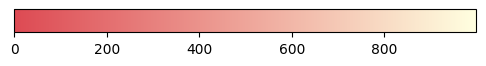

In [38]:
# Define the number of colors in the colormap
num_colors = 1000

# Define anchor points for key colors using hex values
colors1 = [
    "#26005c",  # Dark Blue
    "#274492",
]

# Create a smooth interpolation for the custom colormap
cmap1 = LinearSegmentedColormap.from_list("custom_cmap", colors1, N=num_colors)

# Define anchor points for key colors using hex values
colors2 = [
    "#29ccff",  # light blue
    "#8FCC66",  # green
]

# Create a smooth interpolation for the custom colormap
cmap2 = LinearSegmentedColormap.from_list("custom_cmap", colors2, N=num_colors)

# Define anchor points for key colors using hex values
colors3 = [
    "#dd4a53",  # Orange
    "#cc0047",  # Red
]

# Create a smooth interpolation for the custom colormap
cmap3 = LinearSegmentedColormap.from_list("custom_cmap", colors3, N=num_colors)

colors4 = [
    "#dd4a53",  # Orange
    "#FFFFE0",  # Yellow
]

# Create a smooth interpolation for the custom colormap
cmap4 = LinearSegmentedColormap.from_list("custom_cmap", colors4, N=num_colors)

# Plot the color gradient
plt.figure(figsize=(8, 2))
plt.imshow([list(range(num_colors))], aspect="auto", cmap=cmap4)
plt.gca().set_visible(False)
plt.colorbar(orientation="horizontal")
plt.show()

sizeof_hdr should be 348; set sizeof_hdr to 348
/var/folders/b0/6xxmhnys7hj9g_47_dsjm7c00000gn/T/ipykernel_47056/537859404.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(w_pad=-1, h_pad=-1)


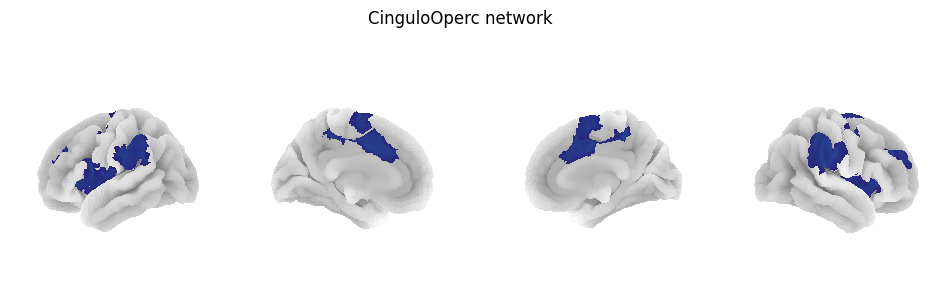

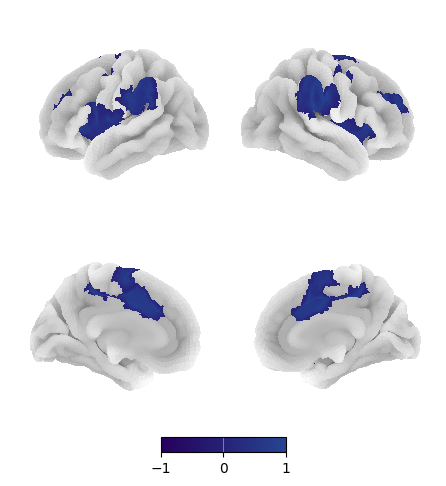

sizeof_hdr should be 348; set sizeof_hdr to 348
/var/folders/b0/6xxmhnys7hj9g_47_dsjm7c00000gn/T/ipykernel_47056/537859404.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(w_pad=-1, h_pad=-1)


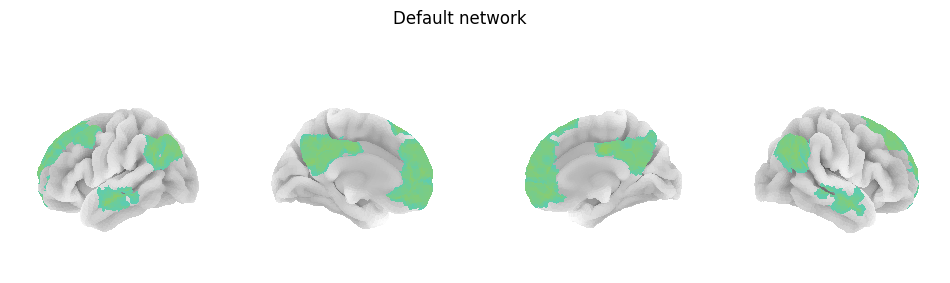

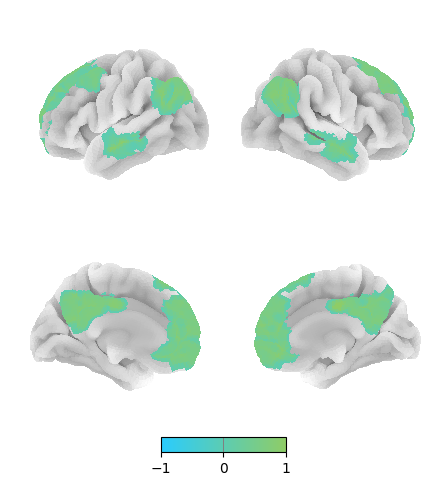

sizeof_hdr should be 348; set sizeof_hdr to 348
/var/folders/b0/6xxmhnys7hj9g_47_dsjm7c00000gn/T/ipykernel_47056/537859404.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(w_pad=-1, h_pad=-1)


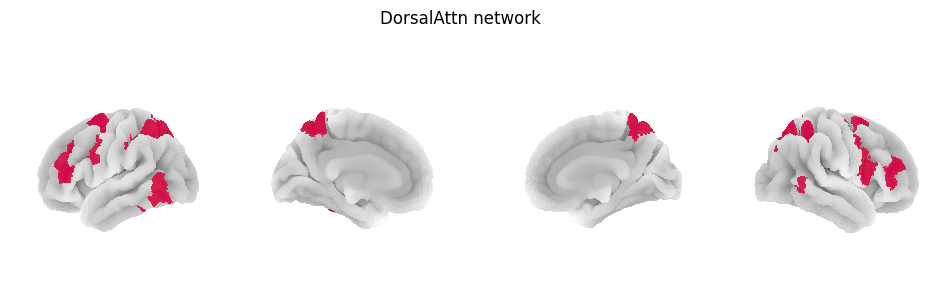

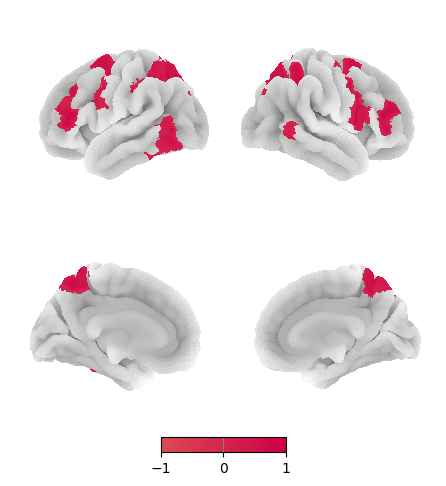

sizeof_hdr should be 348; set sizeof_hdr to 348
/var/folders/b0/6xxmhnys7hj9g_47_dsjm7c00000gn/T/ipykernel_47056/537859404.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(w_pad=-1, h_pad=-1)


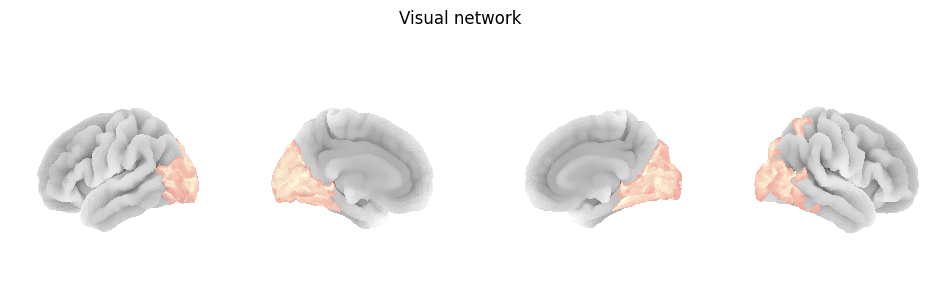

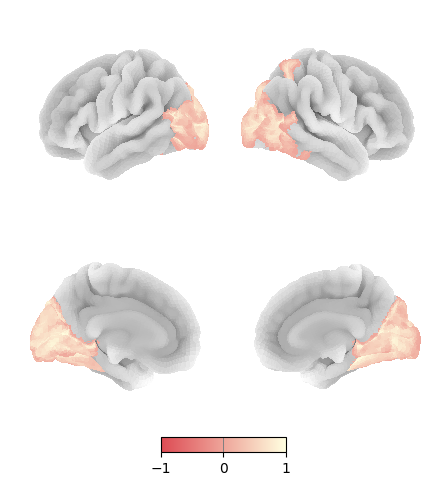

In [39]:


# fetch once
surf = datasets.fetch_surf_fsaverage()

# load your full Gordon atlas
img = nib.load("./gordon_networks_222.nii")
data = img.get_fdata()
affine = img.affine
hdr = img.header

# networks that we care about
# dim 1: 10, 1, 13, 4
# dim 3: 3, 1, 11, 4
networks = [10, 1, 13, 4]
network_map = {10: "CinguloOperc", 1: "Default", 13: "DorsalAttn", 4: "Visual"}

'''networks = [3, 1, 11, 4]
network_map = {3: "SensoriMouth", 1: "Default", 11: "VentralAttn", 4: "Visual"}'''
colors = [cmap1, cmap2, cmap3, cmap4]

for net, color in zip(networks, colors):
    # create a binary mask: 1 where data==net, 0 elsewhere
    mask_vol = (data == net).astype(np.uint8)
    mask_img = nib.Nifti1Image(mask_vol, affine, hdr)

    # plot it
    fig_stat, fig_img = plot_surfaces(
        nifti=mask_img,
        surf=surf,
        cmap=color,  # any cmap is fine for binary
        vmax=1,  # since mask only has 0 & 1
        threshold=0.01,  # hides the zeros
    )
    fig_stat.suptitle(f"{network_map[net]} network", y=0.9)
    plt.show()

sizeof_hdr should be 348; set sizeof_hdr to 348
/var/folders/b0/6xxmhnys7hj9g_47_dsjm7c00000gn/T/ipykernel_47056/537859404.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(w_pad=-1, h_pad=-1)


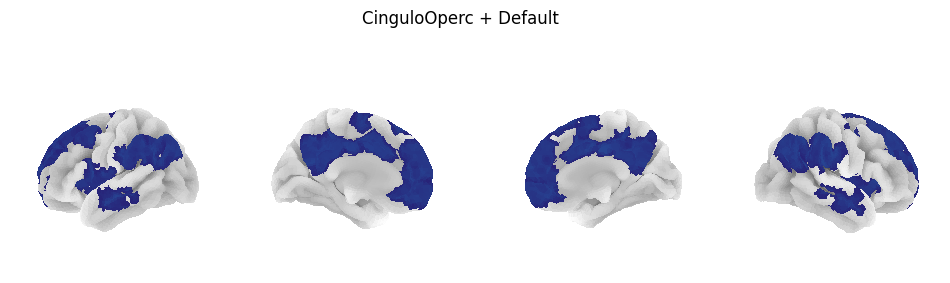

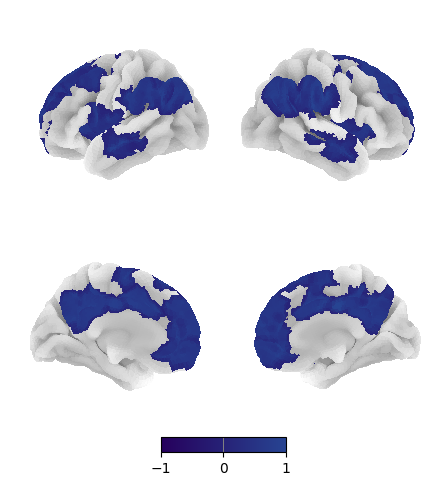

sizeof_hdr should be 348; set sizeof_hdr to 348
/var/folders/b0/6xxmhnys7hj9g_47_dsjm7c00000gn/T/ipykernel_47056/537859404.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(w_pad=-1, h_pad=-1)


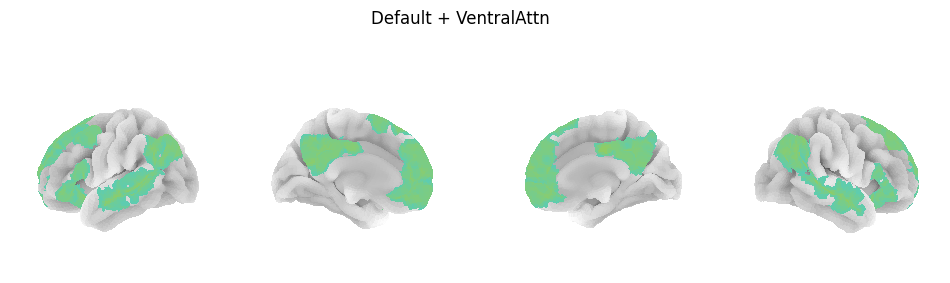

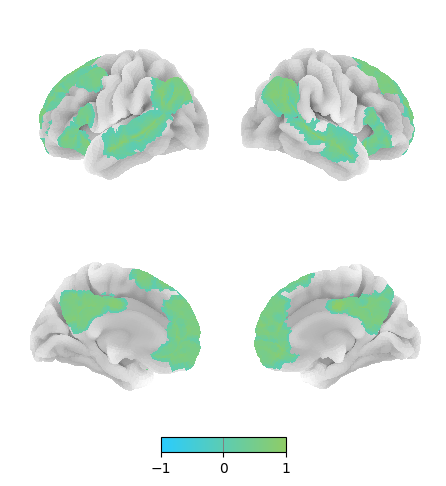

sizeof_hdr should be 348; set sizeof_hdr to 348
/var/folders/b0/6xxmhnys7hj9g_47_dsjm7c00000gn/T/ipykernel_47056/537859404.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(w_pad=-1, h_pad=-1)


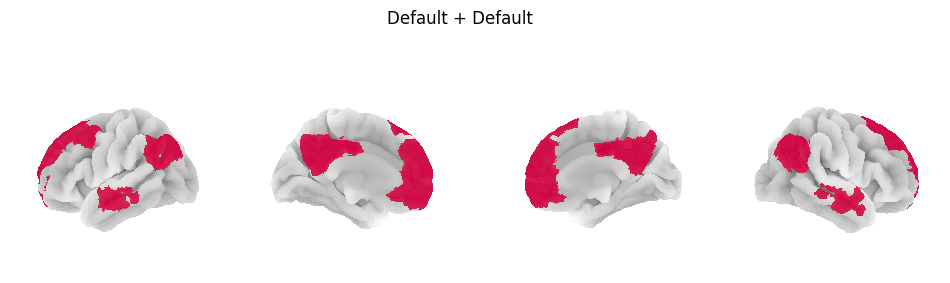

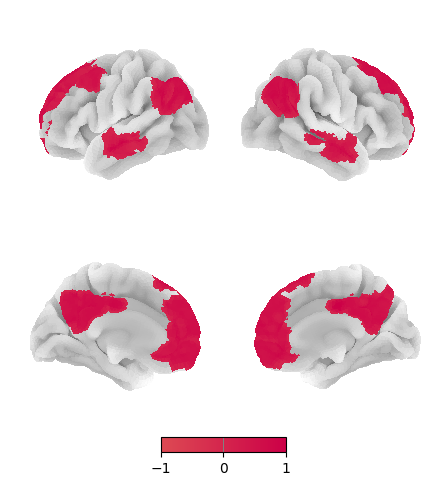

sizeof_hdr should be 348; set sizeof_hdr to 348
/var/folders/b0/6xxmhnys7hj9g_47_dsjm7c00000gn/T/ipykernel_47056/537859404.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(w_pad=-1, h_pad=-1)


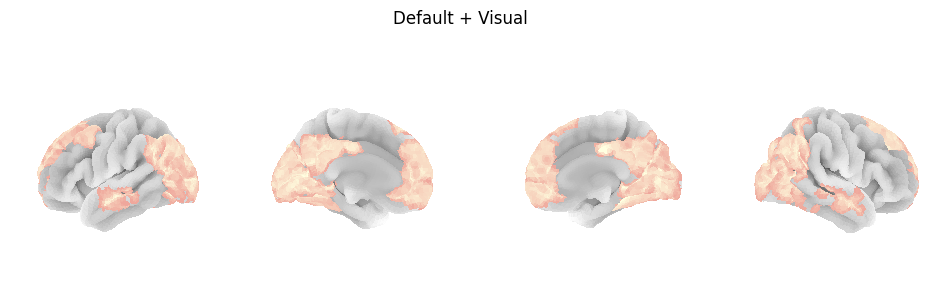

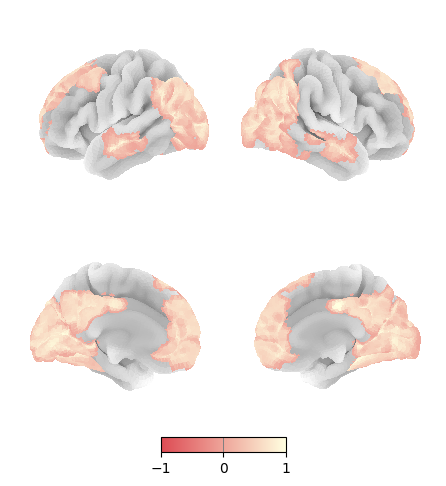

sizeof_hdr should be 348; set sizeof_hdr to 348
/var/folders/b0/6xxmhnys7hj9g_47_dsjm7c00000gn/T/ipykernel_47056/537859404.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(w_pad=-1, h_pad=-1)


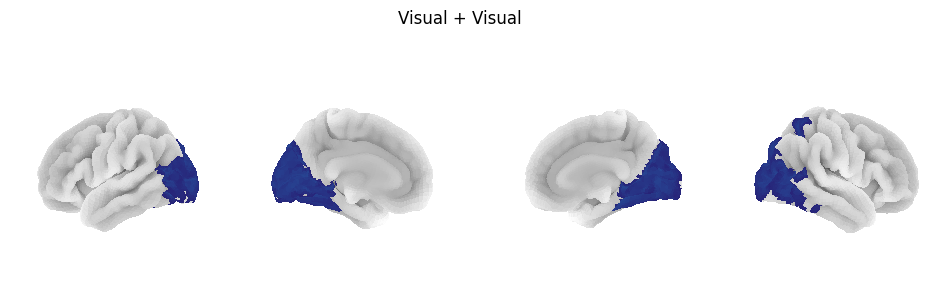

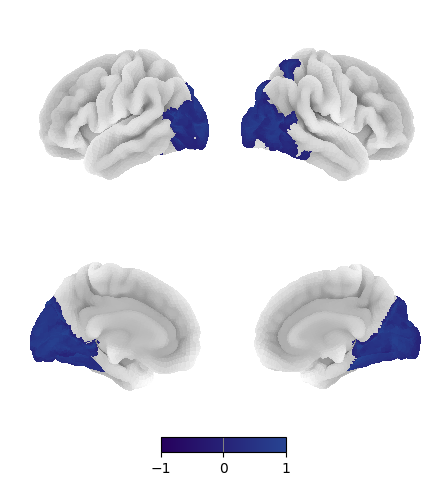

sizeof_hdr should be 348; set sizeof_hdr to 348
/var/folders/b0/6xxmhnys7hj9g_47_dsjm7c00000gn/T/ipykernel_47056/537859404.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(w_pad=-1, h_pad=-1)


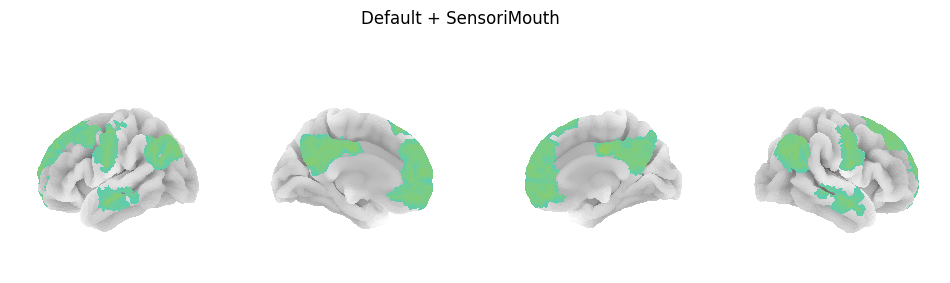

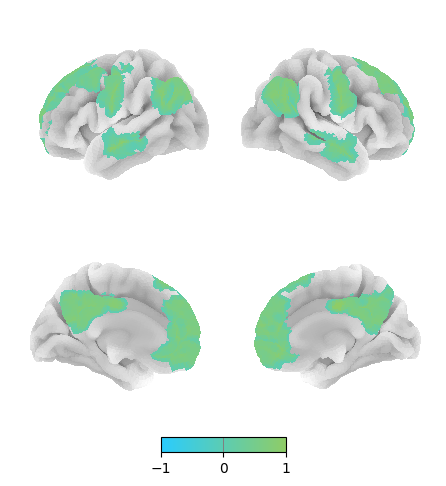

sizeof_hdr should be 348; set sizeof_hdr to 348
/var/folders/b0/6xxmhnys7hj9g_47_dsjm7c00000gn/T/ipykernel_47056/537859404.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(w_pad=-1, h_pad=-1)


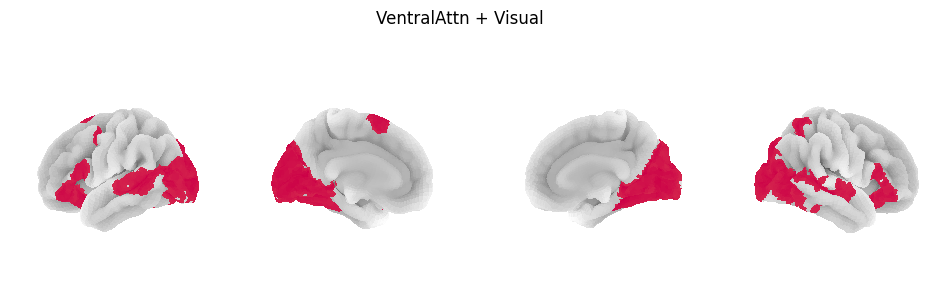

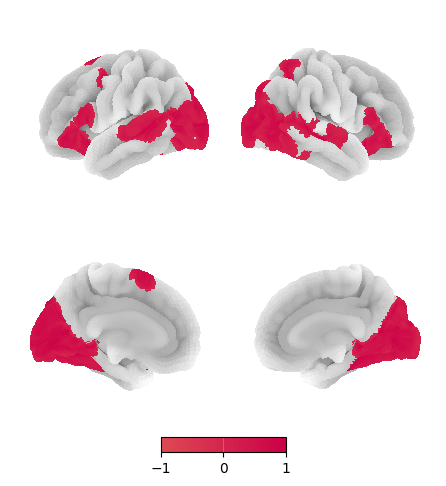

In [41]:
# Fetch fsaverage surface
surf = datasets.fetch_surf_fsaverage()

# Load Gordon atlas
img = nib.load("./gordon_networks_222.nii")
data = img.get_fdata()
affine = img.affine
hdr = img.header

# Define network pairs for each map
network_pairs = [
    (10, 1),  # CinguloOperc + Default
    (1, 11),  # Default + VentralAttn
    (1, 1),  # Default + Default
    (1, 4),  # Default + Visual
    (4, 4),  # Visual + Visual
    (1, 3),  # Default + SensoriMouth
    (11, 4)  # VentralAttn + Visual
]

# Labels
network_map = {
    10: "CinguloOperc",
    1: "Default",
    11: "VentralAttn",
    4: "Visual",
    3: "SensoriMouth",
}

colors = [cmap1, cmap2, cmap3, cmap4, cmap1, cmap2, cmap3]

# Loop through each pair
for (net1, net2), color in zip(network_pairs, colors):
    # Ensure binary 0/1 mask
    mask_vol = np.where((data == net1) | (data == net2), 1, 0).astype(np.uint8)
    mask_img = nib.Nifti1Image(mask_vol, affine, hdr)

    # Title and filename
    label = f"{network_map[net1]} + {network_map[net2]}"
    filename = f"{network_map[net1]}-{network_map[net2]}.nii.gz"
    output_path = join(fig_dir, filename)

    # Save NIfTI
    nib.save(mask_img, output_path)

    # Plot
    fig_stat, fig_img = plot_surfaces(
        nifti=mask_img, surf=surf, cmap=color, vmax=1, threshold=0.01
    )
    fig_stat.suptitle(label, y=0.9)
    plt.show()

In [36]:
rsi_bootdf = pd.read_csv("./derivatives/none-reduced/rni-brain_P-components.csv")
sociocult_bootdf = pd.read_csv("./derivatives/none-reduced/rni-sociocult_Q-components.csv")
variable_df = pd.read_csv("./variable_to_nifti_mapping.csv")

print(rsi_bootdf)

                  Unnamed: 0        V1        V2        V3        V4  \
0   rsfmri_c_ngd_cgc_ngd_cgc  0.166900 -0.031414  0.163430  0.105299   
1    rsfmri_c_ngd_cgc_ngd_ca -0.053671  0.157942  0.109458  0.070879   
2    rsfmri_c_ngd_cgc_ngd_dt -0.224370 -0.259679 -0.101223 -0.004705   
3   rsfmri_c_ngd_cgc_ngd_dla  0.128754  0.081618  0.110008 -0.109035   
4    rsfmri_c_ngd_cgc_ngd_fo -0.173704  0.038306 -0.124875  0.135296   
..                       ...       ...       ...       ...       ...   
61  rsfmri_c_ngd_smm_ngd_vta  0.090719 -0.104000 -0.212907 -0.040524   
62   rsfmri_c_ngd_smm_ngd_vs  0.043918  0.055418  0.238151  0.021985   
63  rsfmri_c_ngd_vta_ngd_vta -0.022812 -0.141838  0.227015 -0.097780   
64   rsfmri_c_ngd_vta_ngd_vs -0.137745 -0.013702 -0.327291 -0.039543   
65    rsfmri_c_ngd_vs_ngd_vs  0.260799 -0.068276  0.066909  0.030154   

          V5        V6        V7        V8        V9  ...       V16       V17  \
0  -0.043089 -0.139590 -0.026246 -0.075051  0.075285  

In [ ]:
# Rename the first column in rsi_bootdf to match variable_df column name (
rsi_bootdf = rsi_bootdf.rename(columns={rsi_bootdf.columns[0]: "Variable"})
variable_df = variable_df.rename(columns={variable_df.columns[0]: "Variable"})

# Keep only the 'Variable' and 'atlas_value' columns
rsi_bootdf = rsi_bootdf[["Variable", "Dimension 1"]]
variable_df = variable_df[["Variable", "atlas_value"]]

# Merge rsi_bootdf with variable_df on 'Variable'
merged_df = pd.merge(rsi_bootdf, variable_df, on="Variable", how="left")

print(merged_df.head())

                   Variable  Dimension 1  atlas_value
0  rsfmri_c_ngd_cgc_ngd_cgc     2.031047         10.0
1   rsfmri_c_ngd_cgc_ngd_ca    -0.729915         10.0
2   rsfmri_c_ngd_cgc_ngd_dt    -3.130818         10.0
3  rsfmri_c_ngd_cgc_ngd_dla     1.734342         10.0
4   rsfmri_c_ngd_cgc_ngd_fo    -2.296964         10.0


sizeof_hdr should be 348; set sizeof_hdr to 348
/var/folders/b0/6xxmhnys7hj9g_47_dsjm7c00000gn/T/ipykernel_40491/537859404.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(w_pad=-1, h_pad=-1)


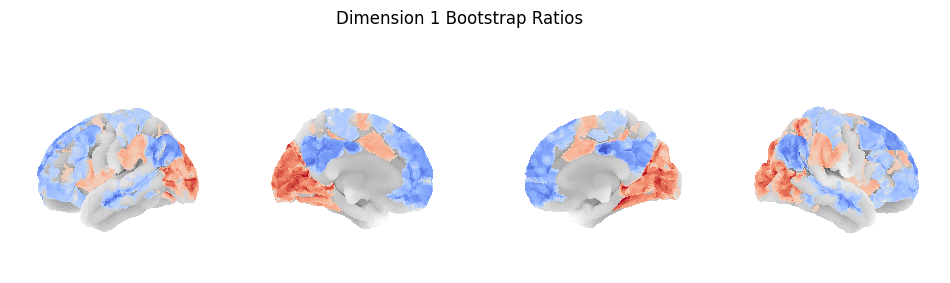

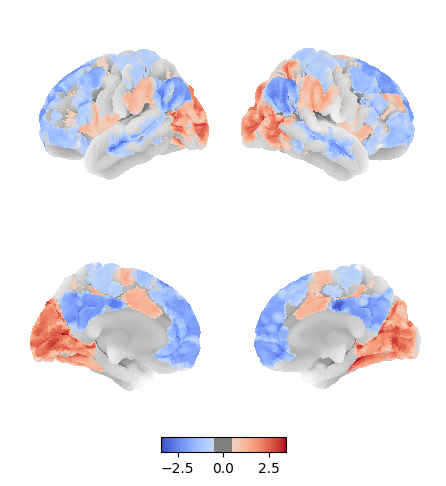

In [ ]:

# Load fsaverage surface
surf = datasets.fetch_surf_fsaverage()

# Load Gordon atlas
gordon_img = nib.load("./gordon_networks_222.nii")
gordon_data = gordon_img.get_fdata()
affine = gordon_img.affine
hdr = gordon_img.header

# Assume merged_df is already loaded and has 'atlas_value' and 'V1' columns

# Create volume to hold V1 values
v1_volume = np.zeros_like(gordon_data)

# Populate volume: set voxel value = V1 score for that atlas_value
for _, row in merged_df.iterrows():
    atlas_val = row["atlas_value"]
    v1_val = row["Dimension 1"]
    if not np.isnan(atlas_val):
        v1_volume[gordon_data == atlas_val] = v1_val

# Convert to NIfTI image
v1_img = nib.Nifti1Image(v1_volume, affine, hdr)

# Define colormap and max value
from matplotlib import cm

cmap = "coolwarm"
vmax = np.abs(merged_df["Dimension 1"]).max()

# Plot
fig_stat, fig_img = plot_surfaces(
    nifti=v1_img,
    surf=surf,
    cmap=cmap,
    vmax=vmax,
    threshold=0.5,  # mask out zeros
)

fig_stat.suptitle("Dimension 1 Bootstrap Ratios", y=0.9)
plt.show()

sizeof_hdr should be 348; set sizeof_hdr to 348
/var/folders/b0/6xxmhnys7hj9g_47_dsjm7c00000gn/T/ipykernel_40491/537859404.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(w_pad=-1, h_pad=-1)


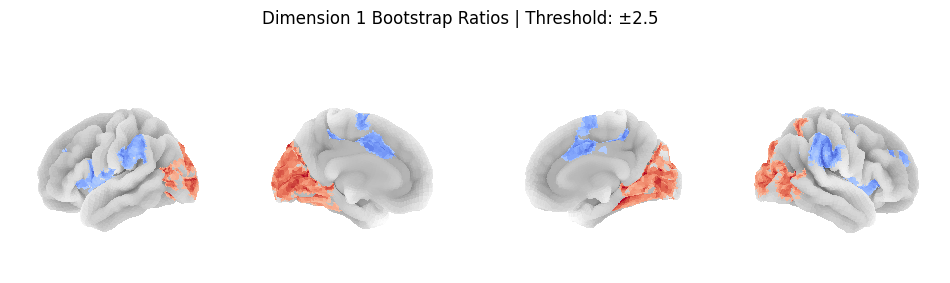

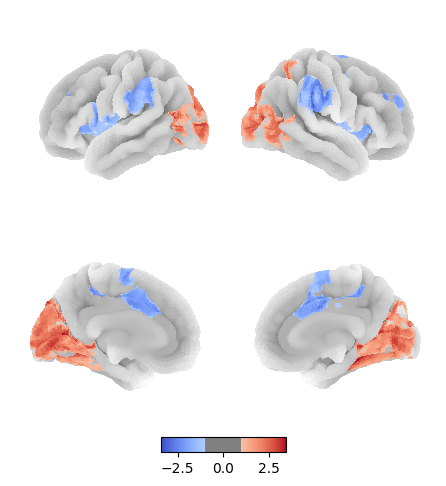

In [ ]:


# Load fsaverage surface
surf = datasets.fetch_surf_fsaverage()

# Load Gordon atlas
gordon_img = nib.load("./gordon_networks_222.nii")
gordon_data = gordon_img.get_fdata()
affine = gordon_img.affine
hdr = gordon_img.header

# Create volume to hold V1 values (initialized to zero)
v1_volume = np.zeros_like(gordon_data)

# Loop through unique atlas values
for atlas_val in merged_df["atlas_value"].dropna().unique():
    # Get all Dimension 1 values for this atlas region
    vals = merged_df.loc[merged_df["atlas_value"] == atlas_val, "Dimension 1"]

    # Filter for bootstrap ratios > 2.5 or < -2.5
    sig_vals = vals[(vals > 2.5) | (vals < -2.5)]

    # If at least one value passes threshold, assign the average to the region
    if not sig_vals.empty:
        mean_val = sig_vals.mean()
        v1_volume[gordon_data == atlas_val] = mean_val

# Convert to NIfTI image
v1_img = nib.Nifti1Image(v1_volume, affine, hdr)

# Define colormap and max value
from matplotlib import cm

cmap = "coolwarm"
vmax = np.abs(merged_df["Dimension 1"]).max()

# Plot 
fig_stat, fig_img = plot_surfaces(
    nifti=v1_img,
    surf=surf,
    cmap=cmap,
    vmax=vmax,
    threshold=1,  # mask out 0s
)

fig_stat.suptitle("Dimension 1 Bootstrap Ratios | Threshold: ±2.5", y=0.9)
plt.show()

## Plot LME

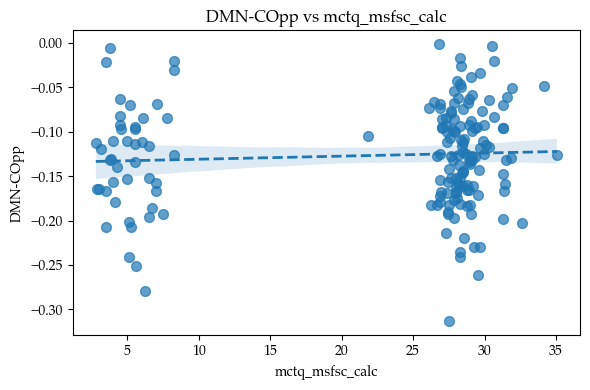

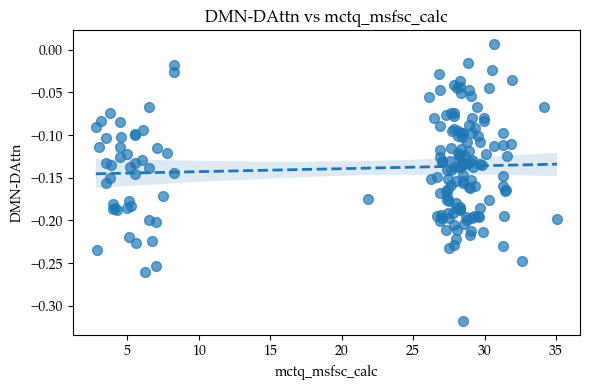

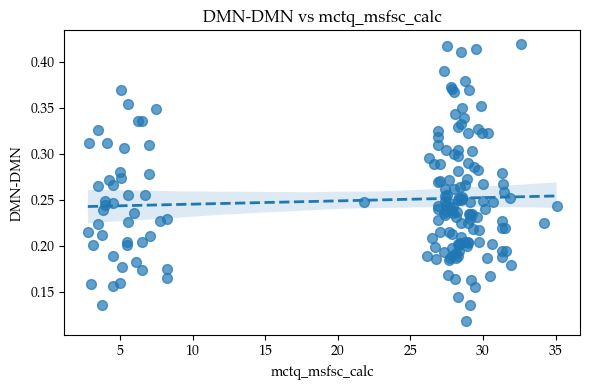

In [22]:
REG_DIR = "./derivatives/regression"

# Set global font properties
plt.rcParams["font.family"] = "Palatino"  # Change to the desired font
plt.rcParams["font.weight"] = "bold"  # Set all fonts to bold

reg_df = pd.read_csv(join(REG_DIR, "regression.csv"))

rsfc_reg_measures = [
    "rsfmri_c_ngd_cgc_ngd_dt",
    "rsfmri_c_ngd_dt_ngd_dla",
    "rsfmri_c_ngd_dt_ngd_dt",
]

# renamed the abide 2 phenotypes
rsfc_map = {
    "rsfmri_c_ngd_cgc_ngd_dt": "DMN-COpp",
    "rsfmri_c_ngd_dt_ngd_dla": "DMN-DAttn",
    "rsfmri_c_ngd_dt_ngd_dt": "DMN-DMN",
}

# phyhealth_col = "resp_wheeze_yn_y"
phyhealth_col = "mctq_msfsc_calc"

for measure in rsfc_reg_measures:
    pretty = rsfc_map.get(measure, measure)

    plt.figure(figsize=(6, 4))
    sns.regplot(
        x=phyhealth_col,
        y=measure,
        data=reg_df,
        scatter_kws={"alpha": 0.7, "s": 50},
        line_kws={"linewidth": 2, "ls": "--", "clip_on": False},  # <-- important
    )
    plt.xlabel(phyhealth_col, weight="bold")
    plt.ylabel(pretty, weight="bold")
    plt.title(f"{pretty} vs {phyhealth_col}", weight="bold")
    plt.tight_layout()
    plt.show()

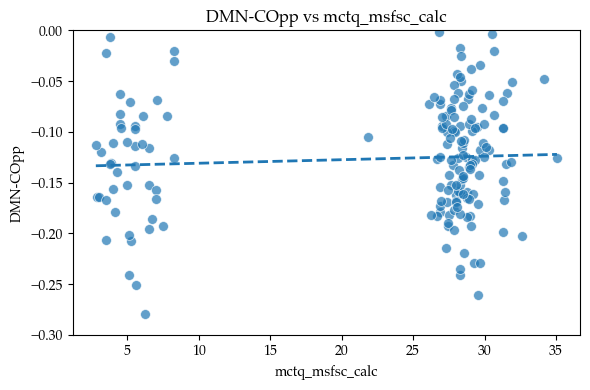

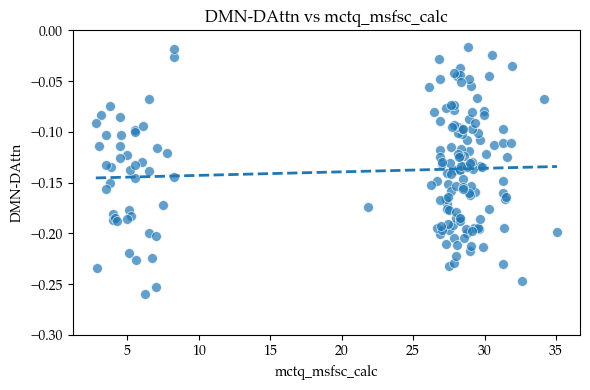

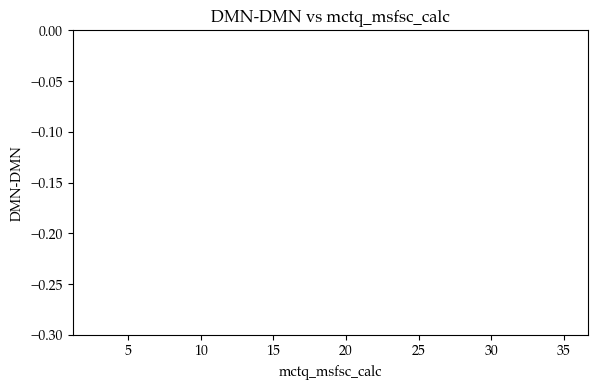

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from scipy.stats import linregress
import numpy as np

REG_DIR = "./derivatives/regression"

plt.rcParams["font.family"] = "Palatino"
plt.rcParams["font.weight"] = "bold"

reg_df = pd.read_csv(join(REG_DIR, "regression.csv"))

rsfc_reg_measures = [
    "rsfmri_c_ngd_cgc_ngd_dt",
    "rsfmri_c_ngd_dt_ngd_dla",
    "rsfmri_c_ngd_dt_ngd_dt",
]

rsfc_map = {
    "rsfmri_c_ngd_cgc_ngd_dt": "DMN-COpp",
    "rsfmri_c_ngd_dt_ngd_dla": "DMN-DAttn",
    "rsfmri_c_ngd_dt_ngd_dt": "DMN-DMN",
}

phyhealth_col = "mctq_msfsc_calc"

for measure in rsfc_reg_measures:
    pretty = rsfc_map.get(measure, measure)

    x = reg_df[phyhealth_col]
    y = reg_df[measure]

    # Fit regression using all data
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    x_vals = np.linspace(x.min(), x.max(), 100)
    y_vals = intercept + slope * x_vals

    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=x, y=y, alpha=0.7, s=50)
    plt.plot(x_vals, y_vals, "--", linewidth=2)  # Full regression line

    plt.xlabel(phyhealth_col, weight="bold")
    plt.ylabel(pretty, weight="bold")
    plt.title(f"{pretty} vs {phyhealth_col}", weight="bold")

    # Zoom in without refitting or redrawing regression
    plt.tight_layout()
    plt.ylim(-0.30, 0.00)  # Set y-axis (z-coordinate) limits
    plt.show()





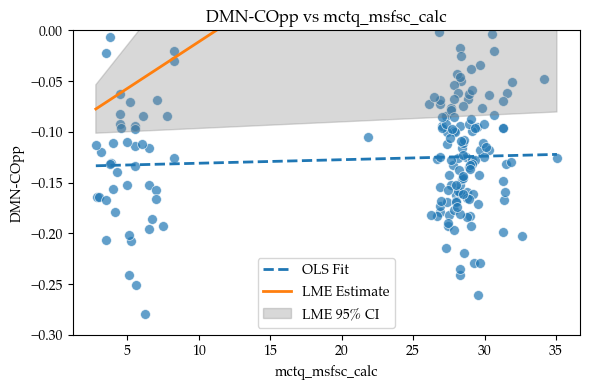

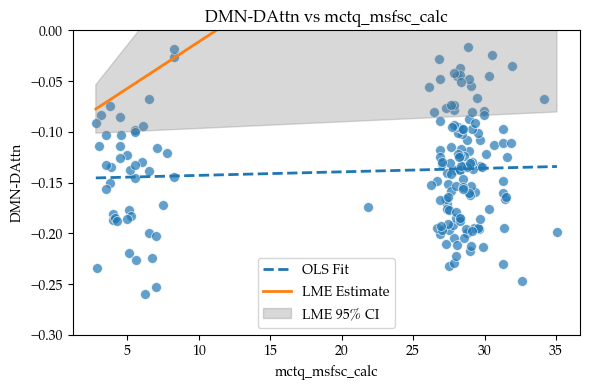

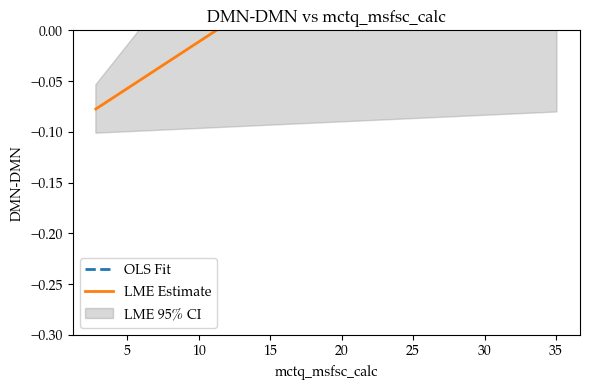

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from scipy.stats import linregress, t
import numpy as np

REG_DIR = "./derivatives/regression"

plt.rcParams["font.family"] = "Palatino"
plt.rcParams["font.weight"] = "bold"

reg_df = pd.read_csv(join(REG_DIR, "regression.csv"))

rsfc_reg_measures = [
    "rsfmri_c_ngd_cgc_ngd_dt",
    "rsfmri_c_ngd_dt_ngd_dla",
    "rsfmri_c_ngd_dt_ngd_dt",
]

rsfc_map = {
    "rsfmri_c_ngd_cgc_ngd_dt": "DMN-COpp",
    "rsfmri_c_ngd_dt_ngd_dla": "DMN-DAttn",
    "rsfmri_c_ngd_dt_ngd_dt": "DMN-DMN",
}

phyhealth_col = "mctq_msfsc_calc"

# From your R LME output
lme_estimate = 0.00919349452795043  # Slope for mctq_msfsc_calc
lme_intercept = -0.103121027119344  # Intercept
lme_se = 0.00432508649601349  # Std. Error
lme_df = 151.05  # Degrees of freedom

for measure in rsfc_reg_measures:
    pretty = rsfc_map.get(measure, measure)

    x = reg_df[phyhealth_col]
    y = reg_df[measure]

    # Fit OLS regression using all data
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    x_vals = np.linspace(x.min(), x.max(), 100)
    y_vals_ols = intercept + slope * x_vals

    # LME model fit
    y_vals_lme = lme_intercept + lme_estimate * x_vals

    # 95% CI for LME slope
    t_crit = t.ppf(0.975, df=lme_df)
    slope_upper = lme_estimate + t_crit * lme_se
    slope_lower = lme_estimate - t_crit * lme_se
    y_upper = lme_intercept + slope_upper * x_vals
    y_lower = lme_intercept + slope_lower * x_vals

    # Plot
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=x, y=y, alpha=0.7, s=50)

    plt.plot(x_vals, y_vals_ols, "--", linewidth=2, label="OLS Fit")
    plt.plot(x_vals, y_vals_lme, "-", linewidth=2, label="LME Estimate")
    plt.fill_between(
        x_vals, y_lower, y_upper, color="gray", alpha=0.3, label="LME 95% CI"
    )

    plt.xlabel(phyhealth_col, weight="bold")
    plt.ylabel(pretty, weight="bold")
    plt.title(f"{pretty} vs {phyhealth_col}", weight="bold")
    plt.ylim(-0.30, 0.00)
    plt.legend()
    plt.tight_layout()
    plt.show()